In [1]:
import nltk
import pandas as pd

## Connect to Mongo DataBase

In [2]:
from pymongo import MongoClient

client = MongoClient()
db = client.tripAdvisor_NusrEt
collection = db.nusret_reviews

cursor = db.nusret_reviews.find({}, {'_id':0,'id':0,'index':0})
list(cursor)

[{'Unnamed: 0': 0,
  'title': 'what a disgrace',
  'reviews': 'The prices have doubled up while the quantity  and quality of the food deteriorated. DISAPPOINTED 😡😡',
  'stars': 2},
 {'Unnamed: 0': 1,
  'title': 'Way overrated!',
  'reviews': 'Despite the hype and the great ambience the food was quite overrated! The meat was too fatty and was not properly cooked to our order. The service was great and the team were super helpful and friendly.',
  'stars': 3},
 {'Unnamed: 0': 2,
  'title': 'Great Dining Experience',
  'reviews': "I have visited Nusret inside the Grand Bazaar and also at the main location in Istanbul. Each time I have visited these restaurants I have never left disappointed. We have tried the lamb chops with fries, a steak dish, a hamburger, salad, etc. Everything has...always tasted fresh and the service is very good. When dining don't miss trying the baklava with vanilla ice cream. It's not to be missed and tastes really good. I will keep returning when visiting Istanbu

In [3]:
cursor = db.nusret_reviews.find({}, {'_id':0,'index':0, 'Unnamed: 0':0})
data = pd.DataFrame(data=list(cursor))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1285 non-null   object
 1   reviews  1285 non-null   object
 2   stars    1285 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 30.2+ KB


In [4]:
data.head()

,title,reviews,stars
0,what a disgrace,The prices have doubled up while the quantity ...,2
1,Way overrated!,Despite the hype and the great ambience the fo...,3
2,Great Dining Experience,I have visited Nusret inside the Grand Bazaar ...,5
3,MUST VISIT,We came here twice because on our first visit ...,5
4,dinner twice - once near the Grand Bazar outle...,Food at the Grand Bazar outlet was wonderful (...,4


## Exploratory data analysis

In [5]:
len(data)

1285

In [6]:
# reviews dağılımı
data.stars.value_counts(normalize=True)

5    0.584436
4    0.202335
3    0.098833
2    0.092607
1    0.021790
Name: stars, dtype: float64

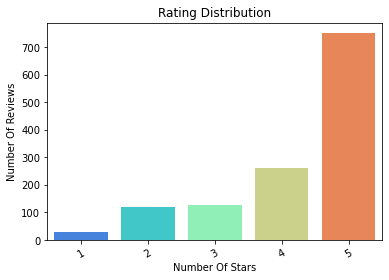

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data.stars.value_counts().sort_values(ascending=True).index,
                 y=data.stars.value_counts().sort_values(ascending=True),palette="rainbow")
plt.title("Rating Distribution")
plt.xlabel("Number Of Stars")
plt.ylabel("Number Of Reviews")
plt.xticks(rotation=30)
plt.savefig("nlp_rating_distribution.jpeg",dpi=300,bbox_inches="tight")

In [8]:
import numpy as np

# 3 yıldızlı yorumları dataframe'den kaldırıyoruz.( kaldırmasamıydık ?)
data = data[data.stars!=3]

# 4/5 yıldızlı yorumlar positive, diğerleri negative 
data['sentiment'] = np.where(data['stars'] >= 4, 'positive', 'negative')

# yeni dataframe, sentiment ve reviews oluşssun.
data = data[['sentiment', 'reviews']]
data.head()

,sentiment,reviews
0,negative,The prices have doubled up while the quantity ...
2,positive,I have visited Nusret inside the Grand Bazaar ...
3,positive,We came here twice because on our first visit ...
4,positive,Food at the Grand Bazar outlet was wonderful (...
5,positive,My experience at Nusr-et was really good. Nice...


In [9]:
# positive ve negative yorumların dağılımı

data.sentiment.value_counts(normalize=True)

positive    0.873057
negative    0.126943
Name: sentiment, dtype: float64

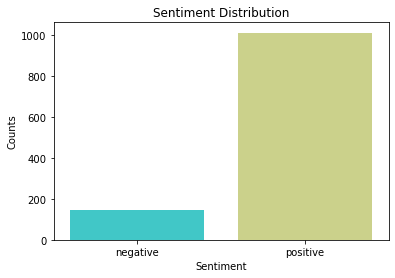

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data.sentiment.value_counts().sort_values(ascending=True).index,
                 y=data.sentiment.value_counts().sort_values(ascending=True),palette="rainbow")

plt.title("Sentiment Distribution")
plt.ylabel("Counts");
plt.xlabel("Sentiment");

plt.savefig("sentiment.jpeg", bbox_inches="tight", dpi =600)

## Preprocess the text

In [11]:
# Text preprocessing zamanı - remove numbers, captial letters and punctuation

import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

data['reviews'] = data.reviews.map(alphanumeric).map(punc_lower)
data.head()

,sentiment,reviews
0,negative,the prices have doubled up while the quantity ...
2,positive,i have visited nusret inside the grand bazaar ...
3,positive,we came here twice because on our first visit ...
4,positive,food at the grand bazar outlet was wonderful ...
5,positive,my experience at nusr et was really good nice...


In [12]:
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
s_words= list(stopwords.words('english'))
stop_words = list(STOPWORDS)+ ["what", "us", "this","well","there","much","us","and","you're","in","where","when","just","how","is","ha","re","are"
                              "hi","aren't", 'couldn','could','couldnt',"couldn't",'did','had','have','must','does','should','was',"it's"
                               "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't", 'let', 'll',"may",'were','is','has','must',
                               'mustn', 'rt', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn','realli','now','got','man','people','a',
                               'becaus','caus',"one","im","guy","someone","two","nearby","i","he's","she's","we","it","they","wouldn’t","i've",
                               'aren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'sdidn', 've',"will","restaurant","şaşlık","ac"]

def remove_emoji(txt):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', txt)
def remove(emoji):
    em = re.compile(r"🥰")
    return em.sub(r"",emoji)
def remove_blank_space(text):
    return re.sub("\s\s+" , " ", text)
def remove_blank2(text):
    text = text.strip()
    return text
def remove_all(ReviewText):
    ReviewText = ReviewText.replace("(<br/>)", "")
    ReviewText = ReviewText.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.replace('(&amp)', '')
    ReviewText = ReviewText.replace('(&gt)', '')
    ReviewText = ReviewText.replace('(&lt)', '')
    ReviewText = ReviewText.replace('(\xa0)', ' ') 
    ReviewText = ReviewText.replace(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', ' ') 
    return ReviewText
def remove_stopwords(txt):
    sentence = []
    s = ""
    for word in txt.split():    
        if(word not in stop_words):      
            sentence.append(word)
            s = ' '.join(sentence)
    return s
    
data.reviews = data.reviews.apply(remove_emoji)
data.reviews = data.reviews.apply(remove)
data.reviews = data.reviews.apply(remove_blank_space)
data.reviews = data.reviews.apply(remove_blank2)
data.reviews = data.reviews.apply(remove_all)
data.reviews = data.reviews.map(remove_stopwords)
data.reviews[0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'prices doubled quantity quality food deteriorated disappointed'

In [13]:
data.head()

,sentiment,reviews
0,negative,prices doubled quantity quality food deteriora...
2,positive,visited nusret inside grand bazaar main locati...
3,positive,came twice first visit tried menu still full p...
4,positive,food grand bazar outlet wonderful true old nus...
5,positive,experience nusr et really good nice welcoming ...


## World Cloud zamanı

--------Top 300 R - All Reviews-------------


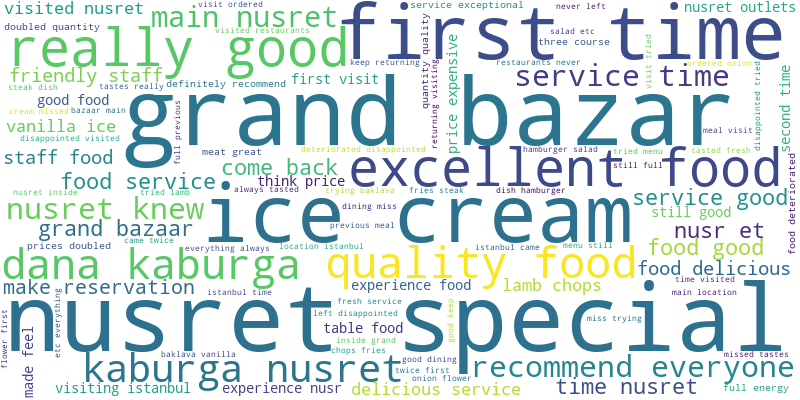

In [14]:
from wordcloud import WordCloud

txt = ','.join(list(data.reviews.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)

# Visualize the word cloud
print("--------Top 300 R - All Reviews-------------")
wordcloud.to_image()

In [15]:
wordcloud.to_file("top300_reviews.png")

--------Negative Reviews-------------


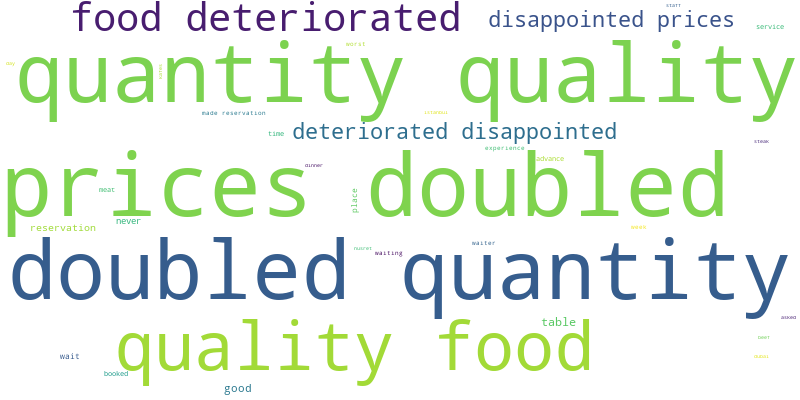

In [16]:
txt = ','.join(list(data[data.sentiment=="negative"].reviews.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)
wordcloud.to_file("n_reviews.png")
# Visualize the word cloud
print("--------Negative Reviews-------------")
wordcloud.to_image()

In [17]:
wordcloud.to_file("negative_reviews.png")

--------Positive Reviews-------------


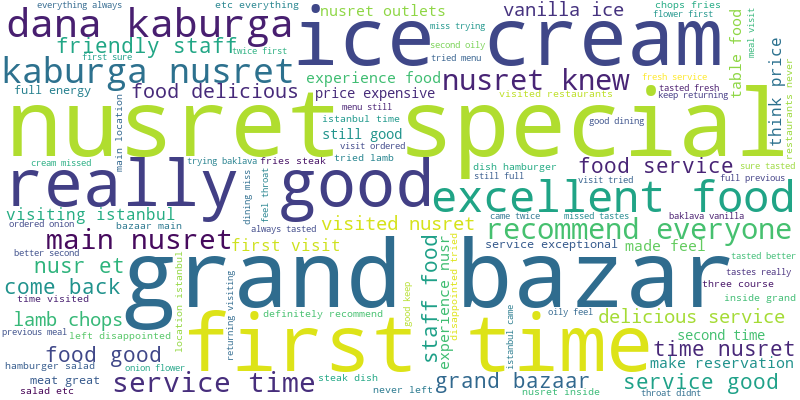

In [18]:
txt = ','.join(list(data[data.sentiment=="positive"].reviews.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)

# Visualize the word cloud
print("--------Positive Reviews-------------")
wordcloud.to_image()

In [19]:
wordcloud.to_file("positive_reviews.png")

In [20]:
from collections import Counter
c = Counter()
for txt in data.reviews.values:
    for word in txt.split():
        c[word] += 1
#en sık kullanılan 10 kelime
c.most_common(10)

[('good', 1260),
 ('nusret', 1034),
 ('food', 950),
 ('time', 796),
 ('service', 593),
 ('visit', 568),
 ('istanbul', 474),
 ('first', 454),
 ('tried', 451),
 ('grand', 449)]

In [21]:
# en az kullanılan 10 kelime
set([w for (w, wc) in c.most_common()[:-11:-1]])

{'die',
 'frequent',
 'gooood',
 'hospitable',
 'matter',
 'sooo',
 'specialties',
 'venues',
 'visitor',
 'yummy'}

## Prepare data for modeling

In [22]:
# datayı X ve y data setlerine ayırıyoruz.

X = data.reviews
y = data.sentiment

In [23]:
# training ve test değerlerini set ediyoruz

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# cv1, Count Vectorizer, word bazında matris oluşturyoruz.

from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,acceptable,action,actually,add,adjust,admit,advance,advertisement,advice,afraid,...,yalikavak,years,yes,yester,york,young,younger,youtube,yumilicious,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# cv2, Count Vectorizer, hem word hem de n-grams bazında (2'li kelimeler) oluşturuyoruz
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,acceptable,acceptable deceptive,action,action istanbul,actually,actually great,add,add kids,adjust,admit,...,yester years,york,york dessert,young,younger,younger visitors,youtube,youtube videos,yumilicious,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Classification zamanı, Logistic Regression ile başlayalım.

In [26]:
# Logistic regresyon modeli oluşturuyoruz

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [27]:
# İlk modeli train yapıyoruz.

lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [28]:
# İkinci modeli train yapıyoruz

lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [29]:
# confusion matrix hazırlamak için fonksiyonu oluşturuyoruz

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

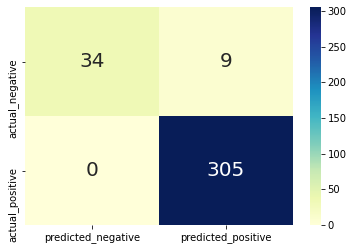

In [30]:
# İlk logistic regresyon modelinin heat map

cm1 = conf_matrix(y_test, y_pred_cv1)

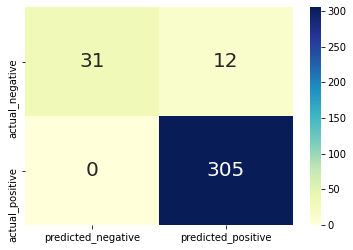

In [31]:
# ikinci logistic regresyon modelinin heat map

cm2 = conf_matrix(y_test, y_pred_cv2)

In [32]:
# logistic regresyonların karsılastırılması

results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.974,0.966
Precision,0.971,0.962
Recall,1.000,1.000
F1 Score,0.985,0.981


İki logistic regresyon modelini karşılaştırdığımızda ilk modelin daha iyi olduğunu görüyoruz.

## Naive Bayes classification modelini deneyelim

In [33]:
# ilk Naive Bayes modeli

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [34]:
# İkinci Naive Bayes modeli

from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

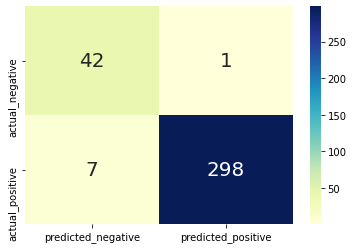

In [35]:
# ilk Naive Bayes modelinin heat map

cm3 = conf_matrix(y_test, y_pred_cv1_nb)

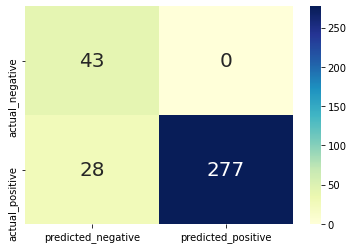

In [36]:
# İkinci Naive Bayes modelinin heat map

cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [37]:
# Logistic Regresyon ve Naive Bayes modellerinin karşılatırılması

results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

,LogReg1,LogReg2,NB1,NB2
Accuracy,0.974,0.966,0.977,0.920
Precision,0.971,0.962,0.997,1.000
Recall,1.000,1.000,0.977,0.908
F1 Score,0.985,0.981,0.987,0.952


İlk Naive Bayes modelin performansı diğerlerinden dahay iyi görünüyor.

## Count Vectorizer yerine TF-IDF kullanalım, bakalım neler değişecek ?

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

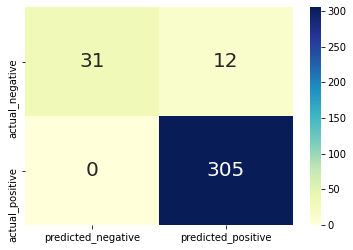

In [40]:
# İlk Logistic regression da TF-IDF fit edelim.

lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

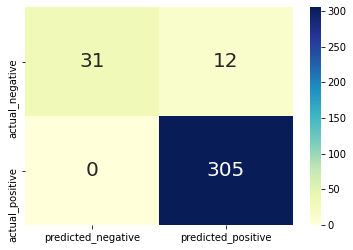

In [41]:
# İkinci Logistic regression da TF-IDF fit edelim

lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

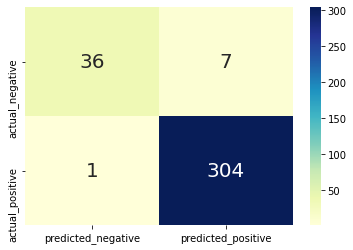

In [42]:
# İlk Naive Bayes modelinde fit edelim

mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

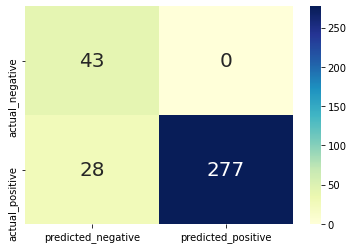

In [43]:
# İkinci Naive Bayes modelini fit edelim

bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [44]:
# Tüm modelleri karşılaştıralım

results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

,LogReg1,LogReg2,NB1,NB2,LR1-TFIDF,LR2-TFIDF,NB1-TFIDF,NB2-TFIDF
Accuracy,0.974,0.966,0.977,0.920,0.966,0.966,0.977,0.920
Precision,0.971,0.962,0.997,1.000,0.962,0.962,0.977,1.000
Recall,1.000,1.000,0.977,0.908,1.000,1.000,0.997,0.908
F1 Score,0.985,0.981,0.987,0.952,0.981,0.981,0.987,0.952


Naive Bayes ilk modeli en iyi classification olarak görülüyor.
TF-IDF recall değerlerinde iyileştirme yaptığını görüyoruz.